In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, concatenate, GRU, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [3]:
df = pd.read_csv('DataFrame.csv')
df.head()

,Datum,Merkmal,Merkmalwert,Bestätigte Menge,Relativer Anteil,USTR10Y,WeizenSpot,CornSpot,GER10Y,WtiOilSpot,SoySpot,AgriSpot
0,2014-01-01,B10,30,0,0.000000,3.006,197.738,187.924,1.941,98.04,246.732,200.399
1,2014-02-01,B10,30,0,0.000000,2.582,182.795,190.254,1.647,96.43,246.293,201.583
2,2014-03-01,B10,30,0,0.000000,2.608,204.039,200.847,1.563,104.92,269.561,221.079
3,2014-04-01,B10,30,48,0.125654,2.755,222.170,215.466,1.581,99.74,281.258,233.772
4,2014-05-01,B10,30,42,0.156134,2.613,241.438,212.924,1.470,99.42,242.195,236.510


In [58]:
df[df["Bestätigte Menge"] > 0].shape[0]

11404

In [68]:
df[df["Merkmalwert"] == 960].head(60)

,Datum,Merkmal,Merkmalwert,Bestätigte Menge,Relativer Anteil,USTR10Y,WeizenSpot,CornSpot,GER10Y,WtiOilSpot,SoySpot,AgriSpot
11760,2020-03-01,N08,960,2,0.005435,1.088,169.063,159.640,-0.620,46.75,177.707,168.283
11761,2020-04-01,N08,960,2,0.015625,0.635,178.072,144.386,-0.470,20.31,169.018,156.770
11762,2020-05-01,N08,960,10,0.038760,0.640,173.667,137.924,-0.586,19.78,166.976,152.006
11763,2020-06-01,N08,960,5,0.014925,0.662,175.363,139.647,-0.393,35.44,168.341,152.876
11764,2020-07-01,N08,960,2,0.007092,0.682,167.447,157.839,-0.400,39.82,175.659,156.907
11765,2020-08-01,N08,960,0,NaN,0.563,175.040,150.953,-0.522,41.01,177.073,158.775
11766,2020-09-01,N08,960,0,0.000000,0.671,185.784,159.110,-0.416,42.76,188.439,169.125
11767,2020-10-01,N08,960,0,0.000000,0.677,187.480,165.360,-0.528,38.57,199.463,176.313
11768,2020-11-01,N08,960,2,0.006734,0.848,196.284,164.195,-0.638,36.63,203.317,185.118
11769,2020-12-01,N08,960,1,0.003268,0.934,187.803,172.881,-0.522,44.55,226.049,188.497


In [4]:
class TimeSeriesSequencer:
    def __init__(self, file_path, date_column, target_column, sequence_length=12):
        """
        Initialisiert die Klasse TimeSeriesSequencer.

        :param file_path: Pfad zur CSV-Datei mit den Daten
        :param date_column: Spaltenname für das Datum
        :param target_column: Spaltenname für die Zielvariable
        :param sequence_length: Länge der Sequenzen
        """
        self.file_path = file_path
        self.date_column = date_column
        self.target_column = target_column
        self.sequence_length = sequence_length
        self.data = None
        self.label_encoders = {}
        self.scaler_X = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        
    def load_data(self):
        """
        Lädt die Daten aus der CSV-Datei und erstellt zusätzliche Features basierend auf dem Datum.
        """
        # Laden der CSV-Datei
        self.data = pd.read_csv(self.file_path)
        # Konvertieren der Datumsspalte in das Datetime-Format
        self.data[self.date_column] = pd.to_datetime(self.data[self.date_column])
        # Erstellen von Jahr- und Monatsspalten
        self.data['Jahr'] = self.data[self.date_column].dt.year
        self.data['Monat'] = self.data[self.date_column].dt.month
        # Erstellen zyklischer Eigenschaften für den Monat
        self.data['Monat_sin'] = np.sin(2 * np.pi * self.data['Monat'] / 12)
        self.data['Monat_cos'] = np.cos(2 * np.pi * self.data['Monat'] / 12)
        
    def encode_categorical_features(self, categorical_features):
        """
        Kodiert kategoriale Merkmale mittels Label-Encoding.

        :param categorical_features: Liste der kategorialen Merkmale
        """
        for feature in categorical_features:
            # Initialisieren des LabelEncoders
            le = LabelEncoder()
            # Anpassen und Transformieren der Daten
            self.data[f'{feature}_encoded'] = le.fit_transform(self.data[feature])
            # Speichern des LabelEncoders
            self.label_encoders[feature] = le

    def normalize_features(self, continuous_features):
        """
        Normalisiert kontinuierliche Merkmale.

        :param continuous_features: Liste der kontinuierlichen Merkmale
        """
        # Normalisieren der kontinuierlichen Merkmale außer "Jahr"
        other_cont_features = [feat for feat in continuous_features if feat != 'Jahr']
        self.data[other_cont_features] = self.scaler_X.fit_transform(self.data[other_cont_features])
        # Normalisieren der "Jahr"-Spalte separat
        self.data[['Jahr']] = MinMaxScaler().fit_transform(self.data[['Jahr']])
        
    def create_sequences(self, continuous_features, encoded_features):
        """
        Erstellt Sequenzen für das Training des Modells.

        :param continuous_features: Liste der kontinuierlichen Merkmale
        :param encoded_features: Liste der kodierten Merkmale
        :return: Sequenzen für die kontinuierlichen Merkmale, kodierten Merkmale, Zielvariablen, Startdaten und Merkmalwerte
        """
        X_cont_seq, X_enc_seq, y_seq, start_dates, merkmalwerte = [], [], [], [], []
        
        # Gruppieren der Daten nach "Merkmalwert"
        for merkmalwert, group in self.data.groupby('Merkmalwert'):
            # Sortieren der Gruppen nach Datum
            group = group.sort_values(by=self.date_column)
            # Auswählen der kontinuierlichen und kodierten Merkmale
            X_continuous = group[continuous_features]
            X_encoded = group[encoded_features]
            
            # Erstellen der Zielsequenzen für die nächsten 12 Monate
            y = pd.concat([group[self.target_column].shift(-i) for i in range(1, 13)], axis=1).dropna()
            y.columns = [f'R_A_{i+1}' for i in range(12)]
            
            # Überprüfen, ob genügend Daten vorhanden sind
            if len(y) < self.sequence_length + 12 - 1:
                continue
            
            # Anpassen der Features an die Zielsequenzen
            X_continuous = X_continuous.iloc[:len(y)]
            X_encoded = X_encoded.iloc[:len(y)]
            
            # Normalisieren der Zielvariablen
            y_scaled = self.scaler_y.fit_transform(y)
            
            for i in range(len(X_continuous) - self.sequence_length - 12 + 1):
                date_seq = group[self.date_column].iloc[i:i+self.sequence_length]
                expected_dates = pd.date_range(start=date_seq.iloc[0], periods=self.sequence_length, freq='MS')
                # Überprüfen, ob die Daten eine kontinuierliche Sequenz bilden
                if date_seq.reset_index(drop=True).equals(expected_dates.to_series().reset_index(drop=True)):
                    X_cont_seq.append(X_continuous.iloc[i:i+self.sequence_length].values)
                    X_enc_seq.append(X_encoded.iloc[i:i+self.sequence_length].values)
                    y_seq.append(y_scaled[i+self.sequence_length:i+self.sequence_length+12])
                    start_dates.append(date_seq.iloc[0])
                    merkmalwerte.append(merkmalwert)
                else:
                    print(f"Skipping non-continuous sequence starting at {date_seq.iloc[0]} for Merkmalwert {merkmalwert}")
                    print(f"Expected dates: {expected_dates}")
                    print(f"Actual dates: {date_seq}")
                       
        print(f"Total sequences created: {len(X_cont_seq)}")
        return np.array(X_cont_seq), np.array(X_enc_seq), np.array(y_seq), start_dates, merkmalwerte

    def get_data(self, categorical_features, continuous_features):
        """
        Lädt die Daten, kodiert kategoriale Merkmale, normalisiert kontinuierliche Merkmale und erstellt Sequenzen.

        :param categorical_features: Liste der kategorialen Merkmale
        :param continuous_features: Liste der kontinuierlichen Merkmale
        :return: Sequenzen für die kontinuierlichen Merkmale, kodierten Merkmale, Zielvariablen, Startdaten und Merkmalwerte
        """
        self.load_data()
        self.encode_categorical_features(categorical_features)
        self.normalize_features(continuous_features)
        encoded_features = [f'{feature}_encoded' for feature in categorical_features]
        return self.create_sequences(continuous_features, encoded_features)

    def show_sequences(self, X_cont_seq, X_enc_seq, y_seq, start_dates, merkmalwerte, idx=0):
        """
        Zeigt eine spezifische Sequenz an.

        :param X_cont_seq: Sequenzen der kontinuierlichen Merkmale
        :param X_enc_seq: Sequenzen der kodierten Merkmale
        :param y_seq: Zielsequenzen
        :param start_dates: Startdaten der Sequenzen
        :param merkmalwerte: Merkmalwerte der Sequenzen
        :param idx: Index der anzuzeigenden Sequenz
        """
        if len(X_cont_seq) == 0:
            print("No sequences available to show.")
            return
        print(f"Continuous Features Sequence for Merkmalwert {merkmalwerte[idx]} starting at {start_dates[idx]}:")
        print(X_cont_seq[idx])
        print("Encoded Features Sequence:")
        print(X_enc_seq[idx])
        print("Target Sequence:")
        print(y_seq[idx])


In [5]:
# Beispielnutzung
file_path = 'DataFrame.csv'
date_column = 'Datum'
target_column = 'Bestätigte Menge'
categorical_features = ['Merkmal', 'Merkmalwert']
continuous_features = ['Jahr', 'Monat_sin', 'Monat_cos', 'USTR10Y', 'WeizenSpot', 'CornSpot', 'GER10Y', 'WtiOilSpot', 'SoySpot', 'AgriSpot']

sequencer = TimeSeriesSequencer(file_path, date_column, target_column)
X_cont_seq, X_enc_seq, y_seq, start_dates, merkmalwerte = sequencer.get_data(categorical_features, continuous_features)

# Daten in Trainings- und Testsets aufteilen
X_cont_train, X_cont_test, X_enc_train, X_enc_test, y_train, y_test, start_dates_train, start_dates_test, merkmalwerte_train, merkmalwerte_test = train_test_split(
    X_cont_seq, X_enc_seq, y_seq, start_dates, merkmalwerte, test_size=0.2, random_state=42, shuffle=True
)

print(f"Total training sequences: {len(X_cont_train)}")
print(f"Total test sequences: {len(X_cont_test)}")

# Anzeigen einer Beispielsequenz (z.B. die erste Sequenz)
sequencer.show_sequences(X_cont_train, X_enc_train, y_train, start_dates_train, merkmalwerte_train, idx=0)


Skipping non-continuous sequence starting at 2014-01-01 00:00:00 for Merkmalwert 40
Expected dates: DatetimeIndex(['2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01'],
              dtype='datetime64[ns]', freq='MS')
Actual dates: 345    2014-01-01
4058   2014-01-01
7576   2014-01-01
346    2014-02-01
4059   2014-02-01
7577   2014-02-01
347    2014-03-01
4060   2014-03-01
7578   2014-03-01
348    2014-04-01
4061   2014-04-01
7579   2014-04-01
Name: Datum, dtype: datetime64[ns]
Skipping non-continuous sequence starting at 2014-01-01 00:00:00 for Merkmalwert 40
Expected dates: DatetimeIndex(['2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01'],
              dtype='datetime64[ns]', freq='MS')
Actual da

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, concatenate, GRU, Reshape
from tensorflow.keras.regularizers import l2

def create_model(input_shape, categorical_shapes, embedding_output_dim=10):
    """
    Erstellt und kompiliert ein Modell zur Vorhersage von Zeitreihendaten.

    :param input_shape: Form der kontinuierlichen Eingabedaten (Sequenzlänge, Anzahl der kontinuierlichen Merkmale)
    :param categorical_shapes: Liste der Dimensionen der kategorialen Eingabedaten (Anzahl der eindeutigen Werte in den kategorischen Merkmalen)
    :param embedding_output_dim: Dimension der Embedding-Ausgabe für die kategorialen Merkmale
    :return: Kompiliertes Keras-Modell
    """
    
    # Eingabeschicht für kontinuierliche Merkmale
    continuous_input = Input(shape=input_shape)
    
    # Erste GRU-Schicht mit Recurrent Dropout
    gru_cont = GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.001))(continuous_input)
    
    # Zweite GRU-Schicht mit Recurrent Dropout
    gru_cont = GRU(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.001))(gru_cont)

    # Listen zum Speichern der Eingabeschichten und Embedding-Schichten für die kategorialen Merkmale
    embedding_inputs = []
    embedding_layers = []

    # Erstellen der Eingabeschichten und Embedding-Schichten für jedes kategoriale Merkmal
    for shape in categorical_shapes:
        # Eingabeschicht für ein kategoriales Merkmal
        input_layer = Input(shape=(12,))
        
        # Embedding-Schicht für das kategoriale Merkmal
        embedding_layer = Embedding(input_dim=shape + 1, output_dim=embedding_output_dim)(input_layer)
        
        # Umwandlung der Embedding-Ausgabe in einen flachen Vektor
        embedding_flatten = Flatten()(embedding_layer)
        
        # Hinzufügen der Eingabe- und Embedding-Schicht zu den Listen
        embedding_inputs.append(input_layer)
        embedding_layers.append(embedding_flatten)

    # Zusammenführung der GRU-Ausgabe und der Embedding-Ausgaben
    merged = concatenate([gru_cont] + embedding_layers)

    # Dense-Schicht mit 64 Neuronen und ReLU-Aktivierung
    dense = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(merged)
    
    # Ausgabeschicht mit 12 * 12 Neuronen (für 12 Zeitpunkte und 12 Zielwerte) und linearer Aktivierung
    output = Dense(12 * 12, activation='linear')(dense)
    
    # Umwandlung der Ausgabe in die Form (12, 12) für 12 Zeitpunkte und 12 Zielwerte
    output = Reshape((12, 12))(output)

    # Erstellung des Modells mit den definierten Eingabe- und Ausgabeschichten
    model = Model(inputs=[continuous_input] + embedding_inputs, outputs=output)
    
    # Kompilierung des Modells mit dem Adam-Optimizer und der mittleren quadratischen Fehlerfunktion
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model


In [39]:
# Modell erstellen
input_shape = (12, len(continuous_features))
categorical_shapes = [int(X_enc_train[:, :, i].max()) for i in range(X_enc_train.shape[2])]
model = create_advanced_model(input_shape, categorical_shapes)

# Callbacks für Early Stopping und Learning Rate Scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Modell trainieren
history = model.fit([X_cont_train] + [X_enc_train[:, :, i] for i in range(X_enc_train.shape[2])],
                    y_train, epochs=100, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0826 - val_loss: 0.0572 - learning_rate: 0.0010
Epoch 2/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0593 - val_loss: 0.0549 - learning_rate: 0.0010
Epoch 3/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0571 - val_loss: 0.0555 - learning_rate: 0.0010
Epoch 4/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0563 - val_loss: 0.0540 - learning_rate: 0.0010
Epoch 5/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0553 - val_loss: 0.0534 - learning_rate: 0.0010
Epoch 6/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0548 - val_loss: 0.0531 - learning_rate: 0.0010
Epoch 7/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0547 - val_loss: 0.0523 - learning_rate: 0.0010
Epoch 8/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0547 - val_loss: 0.0526 - learning_rate: 0.0010
Epoch 9/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0532 - val_loss: 0.0512 - learning_rate: 0.0010


In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, concatenate, GRU, Dropout, Reshape, Conv1D, MaxPooling1D, Attention

def create_advanced_model(input_shape, categorical_shapes, embedding_output_dim=10):
    # Input for continuous features
    continuous_input = Input(shape=input_shape)
    
    # CNN layer to capture local patterns
    cnn_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(continuous_input)
    cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
    
    # First GRU layer with recurrent dropout
    gru_layer = GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(cnn_layer)
    
    # Second GRU layer with recurrent dropout
    gru_layer = GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(gru_layer)
    
    # Attention mechanism
    attention = Attention()([gru_layer, gru_layer])
    
    # Flatten the output for concatenation
    gru_flatten = Flatten()(attention)
    
    # Embedding layers for categorical features
    embedding_inputs = []
    embedding_layers = []
    for shape in categorical_shapes:
        input_layer = Input(shape=(12,))
        embedding_layer = Embedding(input_dim=shape + 1, output_dim=embedding_output_dim)(input_layer)
        embedding_flatten = Flatten()(embedding_layer)
        embedding_inputs.append(input_layer)
        embedding_layers.append(embedding_flatten)
    
    # Combine all layers
    merged = concatenate([gru_flatten] + embedding_layers)
    
    # Dense layers
    dense_layer = Dense(64, activation='relu')(merged)
    dense_layer = Dropout(0.5)(dense_layer)
    output = Dense(12, activation='linear')(dense_layer)
    output = Reshape((12, 1))(output)
    
    # Create and compile model
    model = Model(inputs=[continuous_input] + embedding_inputs, outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

# Example usage
input_shape = (12, 10)  # 12 time steps, 10 continuous features
categorical_shapes = [20, 30]  # Two categorical features with 20 and 30 unique values
model = create_advanced_model(input_shape, categorical_shapes)
model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 12, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 10, 64)    │      1,984 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 5, 64)     │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_14 (GRU)        │ (None, 5, 64)     │     24,960 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_15 (GRU)        │ (None, 5, 64)     │     24,960 │ gru_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_20      │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_21      │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 5, 64)     │          0 │ gru_15[0][0],     │
│ (Attention)         │                   │            │ gru_15[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_12        │ (None, 12, 10)    │        210 │ input_layer_20[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_13        │ (None, 12, 10)    │        310 │ input_layer_21[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 320)       │          0 │ attention[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_13          │ (None, 120)       │          0 │ embedding_12[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 120)       │          0 │ embedding_13[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 560)       │          0 │ flatten_12[0][0], │
│ (Concatenate)       │                   │            │ flatten_13[0][0], │
│                     │                   │            │ flatten_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │     35,904 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 12)        │        780 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 12, 1)     │          0 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 89,108 (348.08 KB)

 Trainable params: 89,108 (348.08 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Modell erstellen
continuous_input = Input(shape=(12, len(continuous_features)))
gru_cont = GRU(64, return_sequences=True)(continuous_input)
gru_cont = GRU(64, return_sequences=False)(gru_cont)

# Embedding-Layer für jede kategorische Eingabe hinzufügen
embedding_inputs = []
embedding_layers = []
for i in range(X_enc_train.shape[2]):
    input_layer = Input(shape=(12,))
    embedding_layer = Embedding(input_dim=int(X_enc_train[:, :, i].max()) + 1, output_dim=10)(input_layer)
    embedding_flatten = Flatten()(embedding_layer)
    embedding_inputs.append(input_layer)
    embedding_layers.append(embedding_flatten)

# Alle Eingaben zusammenführen
merged = concatenate([gru_cont] + embedding_layers)

# Dense-Schicht
dense = Dense(64, activation='relu')(merged)
output = Dense(12 * 12, activation='linear')(dense)  # 12 * 12 für 12 Zeitpunkte und 12 Zielwerte
output = Reshape((12, 12))(output)  # Zielausgabe auf die richtige Form bringen

model = Model(inputs=[continuous_input] + embedding_inputs, outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# Modell trainieren
history = model.fit([X_cont_train] + [X_enc_train[:, :, i] for i in range(X_enc_train.shape[2])],
                    y_train, epochs=100, batch_size=10, validation_split=0.2)


Epoch 1/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0653 - val_loss: 0.0455
Epoch 2/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0449 - val_loss: 0.0427
Epoch 3/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0416 - val_loss: 0.0408
Epoch 4/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0396 - val_loss: 0.0387
Epoch 5/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0380 - val_loss: 0.0367
Epoch 6/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0356 - val_loss: 0.0359
Epoch 7/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0341 - val_loss: 0.0349
Epoch 8/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0330 - val_loss: 0.0343
Epoch 9/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0323 - val_loss: 0.0330
Epoch 10/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0315 - val_loss: 0.0330
Epoch 11/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0318 - val_loss: 0.0328
Epoch 12/100
406/406 ━━━━━━━━━

In [7]:
# Vorhersagen machen
predictions = model.predict([X_cont_test] + [X_enc_test[:, :, i] for i in range(X_enc_test.shape[2])])

# Rückskalieren der Vorhersagen und tatsächlichen Werte
y_test_rescaled = sequencer.scaler_y.inverse_transform(y_test.reshape(-1, 12))
predictions_rescaled = sequencer.scaler_y.inverse_transform(predictions.reshape(-1, 12))


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


Prediction 1:
[ 2.5093691  4.1768513  5.473343   6.7633166  9.227794  12.13055
  9.110465   4.4918995  4.376888   8.919836   7.7770576  9.552182 ]
Actual 1:
[ 5.83098592  1.61971831 13.92957746  5.50704225  7.45070423  9.07042254
  9.3943662   0.          1.94366197  4.53521127  6.8028169   7.77464789]
Prediction 2:
[ 4.115283   5.335756   6.805211   9.183443  12.245273   9.2107525
  4.5570884  4.3819437  8.918126   8.145091   9.466929  11.537338 ]
Actual 2:
[ 1.61971831 13.92957746  5.50704225  7.45070423  9.07042254  9.3943662
  0.          1.94366197  4.53521127  6.8028169   7.77464789 11.98591549]
Prediction 3:
[ 5.2761865  6.704081   9.18854   12.21484    9.290139   4.630248
  4.364639   8.901866   8.16567    9.73728   11.471641  12.802305 ]
Actual 3:
[13.92957746  5.50704225  7.45070423  9.07042254  9.3943662   0.
  1.94366197  4.53521127  6.8028169   7.77464789 11.98591549 12.63380282]
Prediction 4:
[ 6.685798   9.071093  12.22734    9.2742605  4.5883846  4.4048777
  8.90509    

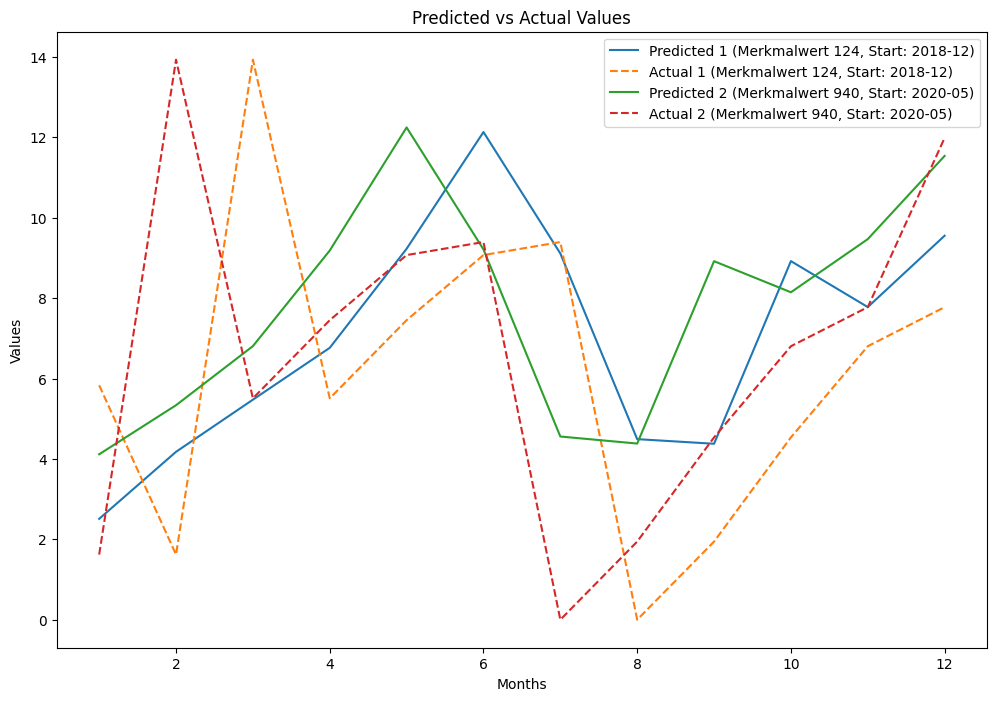

In [10]:
# Vergleich der Vorhersagen mit den tatsächlichen Werten
for i in range(min(len(predictions_rescaled), 5)):  # Zeige die ersten 5 Vorhersagen
    print(f"Prediction {i + 1}:")
    print(predictions_rescaled[i])
    print(f"Actual {i + 1}:")
    print(y_test_rescaled[i])

# Ergebnisse in einer Tabelle anzeigen
results = pd.DataFrame(predictions_rescaled[:5], columns=[f'Predicted_{i+1}' for i in range(12)])
actuals = pd.DataFrame(y_test_rescaled[:5], columns=[f'Actual_{i+1}' for i in range(12)])
results_combined = pd.concat([results, actuals], axis=1)
print(results_combined)

# Grafische Darstellung
plt.figure(figsize=(12, 8))
for i in range(2):  # Zeige die ersten 5 Vorhersagen
    plt.plot(range(1, 13), predictions_rescaled[i], label=f'Predicted {i+1} (Merkmalwert {merkmalwerte_test[i]}, Start: {start_dates_test[i].strftime("%Y-%m")})')
    plt.plot(range(1, 13), y_test_rescaled[i], label=f'Actual {i+1} (Merkmalwert {merkmalwerte_test[i]}, Start: {start_dates_test[i].strftime("%Y-%m")})', linestyle='dashed')
plt.xlabel('Months')
plt.ylabel('Values')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.show()